# Tutorial: Identifying low-frequency somatic mutations in FGFR2 with UMI-tagged smMIPs 

One of the main use cases for amplimap is to accurately quantify the level of mutations found at very low allele frequencies. This is a common challenge when working with somatic mutations, for example in tumours from cancer samples.

For this tutorial, we will look at data from an experiment described in [Selfish mutations dysregulating RAS-MAPK signaling are pervasive in aged human testes](https://www.biorxiv.org/content/early/2018/05/04/314815).
Maher et al conducted a screen for somatic mutations in testes, searching for mutations observed at very low frequencies (<3%).
Due to the technical challenges inherent in calling mutations at such low frequencies, possible hits needed to be validated with a separate method.

To perform this validation, Maher et al resequenced regions around observed mutations using single-molecule molecular inversion probes (smMIPs). Each smMIP was tagged with unique molecular identifiers (UMIs), enabling accurate quantification of variant allele frequencies (VAFs).

Here, we will look at how amplimap can process data from such an experiment and generate VAFs for specific mutations.
While the biological system being studied here is slightly different from somatic mutations in cancer, they can be processed and analysed in exactly the same way.

## Analysis overview

Starting from the raw sequencing reads, we would like to:

- Trim off UMIs and extension/ligation arm sequences
- Align reads to the reference genome
- Group reads with the same UMI together and determine a consensus call for each nucleotide
- Pile up reads in the target regions and count how often we observed each nucleotide at each position
- Compare the observed nucleotide counts to our expectation

## Initial setup

To run this tutorial amplimap needs to be installed and configured already.
Please see [Installation](https://amplimap.readthedocs.io/en/latest/installation.html)
and [Configuration](https://amplimap.readthedocs.io/en/latest/configuration.html) for details.

In particular, you need to have the hg19 (GRCh37) reference genome and the
associated indices prepared for use with your default aligner (see [Reference genome paths](https://amplimap.readthedocs.io/en/latest/configuration.html#reference-genome-paths)).

## Preparing the working directory

For every experiment that we want to process, we create a new working
directory. This will contain all the input files required, as well as
the output generated by amplimap. This makes it easy to keep track of
the data for each experiment, as well as to rerun analyses if required.

To create a directory, we use the standard ``mkdir`` unix command and
change into it with ``cd``:

    mkdir FGFR2
    cd FGFR2

All further commands should now be run inside this working directory.

### reads_in

The first input we need to provide to amplimap is of course the
sequencing data. These can be obtained directly from the sequencer as
``.fastq.gz`` files and should be placed in a directory called [``reads_in``](https://amplimap.readthedocs.io/en/latest/usage.html#reads-in).

[Download the sample data from this tutorial](http://userweb.molbiol.ox.ac.uk/public/koelling/amplimap/tutorial_data/FGFR2.tar)
and extract the ``reads_in`` directory into your working directory. There are many different ways of doing this but
we recommend using ``wget`` and ``tar`` on the command line:

    wget http://userweb.molbiol.ox.ac.uk/public/koelling/amplimap/tutorial_data/FGFR2.tar
    tar xf FGFR2.tar

You can use ``ls`` to check that the files have been extracted to the correct subdirectory:

    ls reads_in

This should display a list of ten fastq.gz files, which represent read 1
and read 2 of five samples:

    1D29_L001_R1_001.fastq.gz
    1D29_L001_R2_001.fastq.gz
    1D7_L001_R1_001.fastq.gz
    1D7_L001_R2_001.fastq.gz
    4C22_L001_R1_001.fastq.gz
    4C22_L001_R2_001.fastq.gz
    4C23_L001_R1_001.fastq.gz
    4C23_L001_R2_001.fastq.gz
    979-blood_L001_R1_001.fastq.gz
    979-blood_L001_R2_001.fastq.gz
    
### probes_mipgen.csv

Next, we need to provide a [probes.csv file](https://amplimap.readthedocs.io/en/latest/usage.html#probes-csv) that describes the used
primer sequences and the regions they are supposed to capture.
In this case, the smMIPs were designed using [MIPGEN](http://shendurelab.github.io/MIPGEN/), which
already generated such a table, albeit in a slightly different format.

amplimap can automatically convert a MIPGEN probe table saved in CSV format into
the amplimap format. 

Create a new plain text file called ``probes_mipgen.csv`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    chr,ext_probe_sequence,lig_probe_sequence,mip_scan_start_position,mip_scan_stop_position,probe_strand,mip_name
    chr10,GCAGTCAACCAAGAAAAG,CCTCAAAAGTTACATTCCGAAT,123276799,123276910,+,2_54_FGFR2_p.S236C
    chr10,CTTGTTTTCTAGGCCGCC,ACTCTGCATGGTTGACAGTTCT,123276860,123276971,-,2_55_FGFR2_p.C227S
    
This is a copy of a probe table created by MIPGEN, including two probes and a subset of the available columns.
As long as these columns are provided, it will be converted into the correct format when we run amplimap.
Any read pair that does not match the primers (arm sequences) specified for either of these probes
will be ignored.
    
### targets.csv

We also need a [file describing the target regions](https://amplimap.readthedocs.io/en/latest/usage.html#targets-csv)
that amplimap should analyse. amplimap will generate pileups for all regions listed in this file,
and ignore all reads outside.
We can provide this file either in BED format (with no column names and 0-based coordinates)
or in CSV format (with column names and 1-based coordinates). In this case we
are doing the latter.

Create a new plain text file called ``targets.bed`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    chr,start,end,id
    chr10,123276799,123276971,FGFR2_C342A

This specifies a single target region, spanning from chr10:123276799-123276971 and called ``FGFR2_C342A``.

### config.yaml

Finally, we create a config.yaml file to set some experiment-specific settings.
We could set [a lot more options](https://amplimap.readthedocs.io/en/latest/configuration.html)
here but in this case set a few of them. All the other options will be left at
the as specified in the default configuration.

Create a new plain text file called ``config.yaml`` (for example using ``nano``
or ``vim``) in your working directory and copy the following text into it:

    general:
      genome_name: "hg19"
      umi_min_consensus_count: 2

    parse_reads:
      umi_one: 5
      umi_two: 5

The first setting tells amplimap to run using the reference genome hg19, as specified in your
[default configuration](https://amplimap.readthedocs.io/en/latest/configuration.html#default-configuration).
If you do not have this reference genome set up there, you can also specify the necessary paths directly
in the ``config.yaml``, by adding the following additional lines and editing the paths to match your local setup:

    paths:
      hg19:
        bwa: "/INSERT/PATH/TO/PREFIX"
        fasta: "/INSERT/PATH/TO/FASTA"
        
For ``bwa`` you would provide the path of the prefix you used when [building the BWA index](http://bio-bwa.sourceforge.net/bwa.shtml#3).
If you are using Bowtie2 as your aligner you can replace ``bwa`` with ``bowtie2`` in the config file and provide the prefix of its index files instead.
For ``fasta`` you would provide the path to the corresponding FASTA file, which needs to have been indexed with ``samtools faidx``.

The ``umi_min_consensus_count`` specifies how many concordant reads are required for a UMI group to be counted.
By setting this to two we will ignore all UMI groups that are only supported by one read, or where we don't have
at least two reads that agree.

Finally, the ``umi_one`` and ``umi_two`` settings under ``parse_reads`` tell amplimap how long the UMI sequences on read one
and read two are. It is important to get this setting right, since setting an incorrect value here will probably result in none of the reads being matched to the expected probe arms. 

## Running amplimap

Now we can run amplimap using the ``pileups`` target. First we will do a dry-run to confirm that all input files can be found:

    amplimap pileups
    
This should output a long list of commands, ending with these lines:

    Job counts:
        count	jobs
        5	align_pe
        1	convert_mipgen_probes
        1	convert_targets_csv
        5	do_pileup
        10	link_reads
        5	parse_reads_pe
        1	pileup_agg
        1	pileups
        1	start_analysis
        5	stats_alignment
        1	stats_alignment_agg
        1	stats_reads_agg
        1	stats_samples_agg
        2	tool_version
        40        
    amplimap dry run successful. Set --run to run!

You can see how amplimap is planning to run 5 alignment jobs (align_pe) and 5 pileups (do_pileup), corresponding to the 5 samples we are analysing.

Having confirmed that everything looks as expected, we can run amplimap:

    amplimap pileups --run

This will take a few minutes to complete. It would be much faster if we
ran jobs in parallel (for example using a cluster), but we are not
doing that for the purposes of this tutorial.

## Analysing the results

amplimap has now processed our reads, aligned them to the reference genome and calculated read counts for each site and each sample.
All of the output files have been placed into the ``analysis`` directory.

Since we told it that our reads contained UMIs, amplimap has also grouped all raw reads sharing the same UMI into UMI groups.
For each UMI group and each position, amplimap has determined a consensus call, which reflects the most commonly observed call among all reads in the UMI group.
This way, biases due to DNA amplification duplicates and random sequencing errors have been minimized, resulting in highly accurate VAFs.

### analysis/reads_parsed/

As a first step, let's have a look at the ``stats_reads.csv`` file, which tells us some general statistics about the number of reads and the number of UMI groups for the different probes and samples. It contains one row for each sample/probe combination, with a set of columns providing details such as the raw number of read pairs (``read_pairs``), the number of unique UMIs (``umis_total``), the min/mean/max number of read pairs supporting a UMI group (``umis_coverage_min/mean/max``), the different percentiles of the UMI coverage and the number of UMIs that had at least 2/3/5/10 supporting read pairs:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

stats_reads = pd.read_csv('analysis/reads_parsed/stats_reads.csv')
stats_reads

,sample,probe,read_pairs,umis_total,umis_coverage_min,umis_coverage_mean,umis_coverage_max,umis_coverage_05pct,umis_coverage_25pct,umis_coverage_median,umis_coverage_75pct,umis_coverage_95pct,umis_coverage_ge_2,umis_coverage_ge_3,umis_coverage_ge_5,umis_coverage_ge_10
0,1D29,2_54_FGFR2_p.S236C,25540,7829,1,3.262230,34,1.0,2.0,3.0,4.0,8.0,4211,2740,1084,118
1,1D29,2_55_FGFR2_p.C227S,41205,11506,1,3.581175,43,1.0,2.0,3.0,5.0,8.0,6748,4590,1941,272
2,1D7,2_54_FGFR2_p.S236C,22888,8308,1,2.754935,39,1.0,1.0,2.0,4.0,6.0,3566,2091,692,69
3,1D7,2_55_FGFR2_p.C227S,34098,11237,1,3.034440,88,1.0,1.0,2.0,4.0,7.0,5395,3303,1265,148
4,4C22,2_54_FGFR2_p.S236C,22911,8689,1,2.636782,80,1.0,1.0,2.0,3.0,6.0,3485,1887,619,67
5,4C22,2_55_FGFR2_p.C227S,31577,11080,1,2.849910,44,1.0,1.0,2.0,4.0,7.0,4897,2830,972,123
6,4C23,2_54_FGFR2_p.S236C,24682,8136,1,3.033677,46,1.0,2.0,2.0,4.0,7.0,4027,2478,911,87
7,4C23,2_55_FGFR2_p.C227S,33085,10528,1,3.142572,40,1.0,2.0,3.0,4.0,7.0,5421,3367,1247,143
8,979-blood,2_54_FGFR2_p.S236C,22408,8814,1,2.542319,122,1.0,1.0,2.0,3.0,6.0,3313,1828,563,47
9,979-blood,2_55_FGFR2_p.C227S,37032,12668,1,2.923271,142,1.0,1.0,2.0,4.0,7.0,5631,3401,1252,159


To see if the probes were well-balanced and the samples were adequately covered, we can make boxplots for the number of UMIs with at least two supporting read pairs, per probe and sample:

Text(0.5,0.98,'')

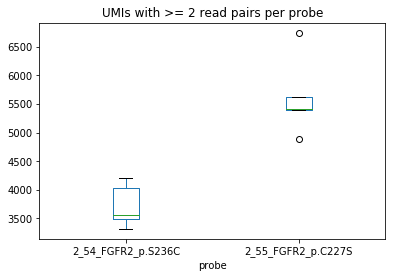

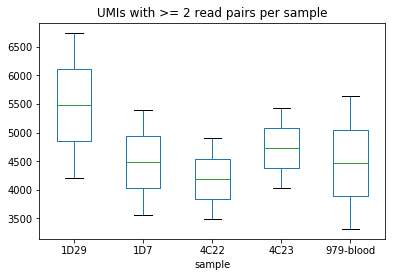

In [2]:
stats_reads.boxplot(column='umis_coverage_ge_2', by='probe', grid=False)
plt.title("UMIs with >= 2 read pairs per probe")
plt.suptitle("")

stats_reads.boxplot(column='umis_coverage_ge_2', by='sample', grid=False)
plt.title("UMIs with >= 2 read pairs per sample")
plt.suptitle("")

We can also visualize the relationship between read pairs and the number of UMI groups we observed:

Text(0.5,1,'UMIs with >= 2 read pairs vs. raw read pairs')

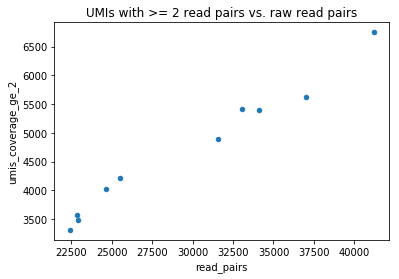

In [3]:
stats_reads.plot.scatter(x='read_pairs', y='umis_coverage_ge_2')
plt.title("UMIs with >= 2 read pairs vs. raw read pairs")

### analysis/pileups/

amplimap generated a pileup table from the UMI groups, telling us how many UMI groups support a given call at each basepair of the target region.
There is one pileup table for each individual sample, as well as several summary tables that contain all of the samples aggregated together.

We will use these tables to look for the mutations we wanted to validate. In this tutorial, we will use Python and pandas for this, but the same thing could be done in R, or by just filtering the tables in Excel.

Based on previous work, we expected to find the following mutations:

- A ``G>C`` mutation at 123276865 (GRCh37 coordinates) in samples 4C22 (at approx. 0.13%) and 4C23 (0.24%)
- An ``A>T`` mutation at 123276893 (GRCh37 coordinates) in samples 1D29 (at approx. 2.95%) and 1D7 (0.33%).

The 979-blood sample acts as a negative control which should not show any mutations. Thus, the VAF we observe in this sample gives us an idea about the error rate we can expect.

All the information we need to check this is contained in the ``pileups_long_detailed.csv`` summary table, and in particular in the ``number_called_hq`` and ``count_hq_A/C/G/T`` columns. Here, the ``_hq`` denotes that the calls were filtered by base quality, with the minimum threshold being set to 30 by default.

In [4]:
d = pd.read_csv('analysis/pileup/pileups_long_detailed.csv')

d.loc[
    d.pos.isin([123276865, 123276893]),
    ['sample', 'chr', 'pos', 'ref', 'number_called_hq', 'nonref_hq_count_fraction', 'count_hq_A', 'count_hq_C', 'count_hq_G', 'count_hq_T']
].sort_values(['pos', 'sample'])

,sample,chr,pos,ref,number_called_hq,nonref_hq_count_fraction,count_hq_A,count_hq_C,count_hq_G,count_hq_T
65,1D29,chr10,123276865,G,13935,0.000072,1,0,13934,0
237,1D7,chr10,123276865,G,12888,0.000155,2,0,12886,0
409,4C22,chr10,123276865,G,12749,0.001412,3,15,12731,0
581,4C23,chr10,123276865,G,12924,0.001470,2,17,12905,0
753,979-blood,chr10,123276865,G,13649,0.000073,0,0,13648,1
93,1D29,chr10,123276893,A,13916,0.030181,13496,0,1,419
265,1D7,chr10,123276893,A,12890,0.003258,12848,0,2,40
437,4C22,chr10,123276893,A,12757,0.000157,12755,0,2,0
609,4C23,chr10,123276893,A,12931,0.000077,12930,0,1,0
781,979-blood,chr10,123276893,A,13650,0.000513,13643,0,6,1


The first thing we see is that we thoroughly covered both sites, with around 13,000 unique UMIs observed in all five samples.
The vast majority of these UMI groups supported the reference allele, agreeing with our expectation that any potential mutations would be observed at very low frequencies.
The background frequency of erroneous non-reference calls also seems to be low, with ``nonref_hq_count_fraction``, which is the proportion of UMI groups with a call different from the reference base, at 0.007% and 0.05% for the blood control.

Looking at samples 4C22 and 4C23 we see a non-reference call rate (``nonref_hq_count_fraction``) above the background at position 123276865 but only a low rate at position 123276893, as expected. The observed VAF for the G>C mutation at 123276865 was 15 / 12749 = 0.12% and 17 / 12924 = 0.13%. The former of these is similar to the expected level (0.13%), while the latter is a bit lower (expected 0.24%). However, a small mismatch here is not surprising given the inaccuracies involved in VAF quantification during the previous screen.

Similarly, samples 1D29 and 1D7 show a non-reference call rate much higher than the background at 123276893 but low at 123276865. The VAFs for the A>T mutation are 419 / 13916 = 3.0% and 40 / 12890 = 0.31%, very close to the VAFs we expected to see.

If we wanted to look at the counts for a specific sample in more detail, we could have a look at the per-sample pileup files. For example, here is all the available data for the mutation site in 1D29:

In [5]:
d = pd.read_csv('analysis/pileup/1D29.pileup.csv')
d.loc[d.pos == 123276893].iloc[0]

chr                                                                            chr10
pos                                                                        123276893
target_id                                                                FGFR2_C342A
target_type                                                                   target
ref                                                                                A
alts                                                                             G;T
raw_coverage                                                                  133357
umi_groups                                                                     16511
unique_raw_umis                                                                24551
unique_mate_starts                                                                 1
group_below_min                                                                 2580
group_no_majority                                                

There is a lot of additional information here that may be helpful to understand the underlying data. For example we can see that this site was covered by two probes. Between them, we had 133357 read pairs covering this site (``raw_coverage``) which belonged to 16511 UMI groups (``umi_groups``). Of these, 2580 UMI groups didn't have at least two supporting reads (``groups_below_min``), so they were filtered out.

The mean base call quality score was close to 39 for both nucleotides (``phred_A``, ``phred_T``), suggesting that it is very unlikely that they were due to a sequencing error. The high quality of the data is further confirmed by the fact that the nucleotide counts not filtered for base quality (``count_A/C/G/T``) are actually the same as the quality-filtered ones (``count_hq_A/C/G/T``), telling us that not a single UMI group had a phred score of < 20 at this site. Maybe we could consider setting an even stricter threshold to remove the few erroneous reads we observed in the blood sample.

## Identifying new low-frequency mutations

In addition to looking for expected mutations, we could also use amplimap to look for new ones. This could be used to identify variants present in tumour samples, but not present in matched normal tissue samples, or to identify subclonal mutations in distinct parts of a tumour. A basic approach to this could be to look for sites where in one of the samples we observed VAFs far above the background levels in one of the samples.

For this part of the tutorial we will assume that we have no prior knowledge of the variants in the samples. We will analyse all of the targeted bases in exon 7 of FGFR2, a region of about 200bp.

To estimate the background level, we will simply use the non-reference allele fraction of the blood sample. In the case of tumour samples this would be the matched normal sample. If we had more samples, we might be able to use something more sophisticated here, for example considering the median non-reference fraction and its variance across all samples to build a better estimate of the expected background.

Let's look at the non-reference fraction in the blood sample across the entire targeted region:

In [6]:
d = pd.read_csv('analysis/pileup/pileups_long_detailed.csv')

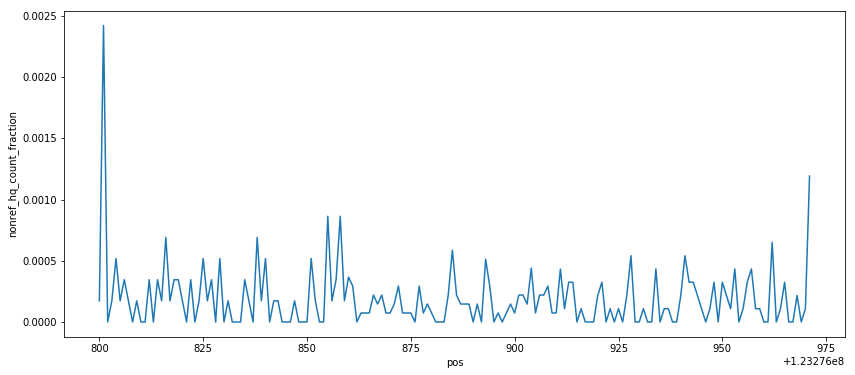

In [7]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='pos', y='nonref_hq_count_fraction', data = d[d['sample'] == '979-blood'])

It looks like the background stays below 0.1% for almost the entire targeted region, although it does go up towards the ends. This may be related to the fact that the middle region was covered by two probes, doubling our coverage and decreasing the relative error rate.

Finally, we can look for sites that may show real signal, using an arbitrary threshold of 0.1% above the background level:

In [ ]:
#add nonref_hq_count_fraction from blood sample to all other samples as background_fraction 
data_with_background = d[d['sample'] != '979-blood'].merge(
    d.loc[d['sample'] == '979-blood', ['chr', 'pos', 'nonref_hq_count_fraction']].rename(
        columns = {'nonref_hq_count_fraction': 'background_fraction'}
    ),
    on = ['chr', 'pos']
)
data_with_background['threshold'] = (data_with_background['background_fraction'] + 1e-3)
data_with_background['above_background'] = data_with_background['nonref_hq_count_fraction'] > data_with_background['threshold']

data_with_background.loc[
    data_with_background['above_background'],
    ['sample', 'chr', 'pos', 'ref', 'number_called_hq', 'nonref_hq_count_fraction', 'count_hq_A', 'count_hq_C', 'count_hq_G', 'count_hq_T', 'background_fraction']
]

,sample,chr,pos,ref,number_called_hq,nonref_hq_count_fraction,count_hq_A,count_hq_C,count_hq_G,count_hq_T,background_fraction
6,4C22,chr10,123276801,A,5931,0.007587,5886,0,45,0,0.002421
7,4C23,chr10,123276801,A,6081,0.008716,6028,0,53,0,0.002421
262,4C22,chr10,123276865,G,12749,0.001412,3,15,12731,0,0.000073
263,4C23,chr10,123276865,G,12924,0.001470,2,17,12905,0,0.000073
372,1D29,chr10,123276893,A,13916,0.030181,13496,0,1,419,0.000513
373,1D7,chr10,123276893,A,12890,0.003258,12848,0,2,40,0.000513


In this case, we recovered the two mutations previously described, plus a third one at position 123276801 with a VAF of 0.76%/0.87% in samples 4C22 and 4C23. However, this is actually the site with the highest background level in the entire region (0.24%), so we would be extremely sceptical about this site and should probably discard it as a technical artefact.
In fact, this position was covered by a single probe (note the coverage of this site compared to the other two positions) and is at the end of a polyA tract. Therefore, the variant may represent an artefact of slippage at the polyA tract.

Nevertheless, if had a larger set of samples to work with, we could use this approach to identify potential novel mutations.

In [ ]:
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='pos', y='nonref_hq_count_fraction',
    size = 'above_background', sizes = {True: 100, False: 20},
    style = 'above_background',
    hue = 'ref',
    data = data_with_background
)